# Homework 10:

Replicate the steps of the California housing example of Section 10.14.1 (with some library implementation) unless you really want to go all-in with this) to explore potential dependencies and interactions in the features of your data.


In [92]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv('/Users/MayraBerrones/Documents/VisualCode/data_bcw.csv')
dataset.drop(['Unnamed: 32', 'id'], inplace= True, axis = 1)
label_encoder = LabelEncoder()
dataset.iloc[:,0] = label_encoder.fit_transform(dataset.iloc[:,0]).astype('int64')
dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [94]:
target = 'diagnosis'

features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

X, y = dataset[features].values, dataset[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2311)
y_overall_median = np.median(y)


In [95]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_train_median = np.median(y_train)
y_test_hat = np.full(shape=y_test.shape, fill_value=y_train_median)
const_mae = mean_absolute_error(y_test, y_test_hat)
print(f'MAE of optimal constant predictor {const_mae:.2f}')

MAE of optimal constant predictor 0.44


In [96]:
from catboost import CatBoostRegressor

cb_reg = CatBoostRegressor(
    iterations=1500,
    loss_function='MAE'
).fit(
    X_train, y_train,
    verbose=False,
    # include train into eval_set to calculate error curve for it
    # don't to it when selecting the best model
    eval_set=[(X_train, y_train), (X_test, y_test)]
)

In [97]:
y_test_hat = cb_reg.predict(X_test)
cb_mae = mean_absolute_error(y_test, y_test_hat)
cb_r2 = r2_score(y_test, y_test_hat)
print(f'CatBoost MAE={cb_mae:.2f}, R^2={cb_r2:.2f}')

CatBoost MAE=0.08, R^2=0.78


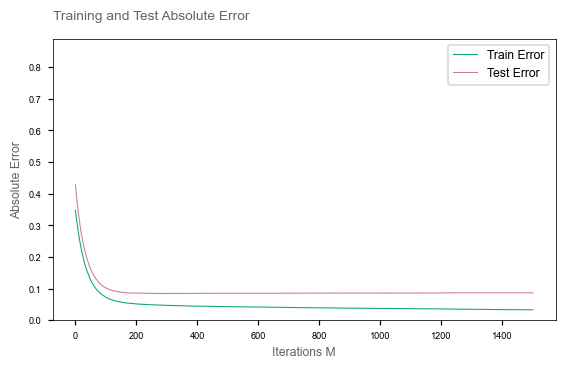

In [98]:
train_error = cb_reg.get_evals_result()['validation_0']['MAE']
test_error = cb_reg.get_evals_result()['validation_1']['MAE']
fig, ax = plt.subplots(figsize=(5.9, 3.39), dpi=110)
ax.set_xlabel('Iterations M', color=GRAY4, fontsize=8)
ax.set_ylabel('Absolute Error', color=GRAY4, fontsize=8)
ax.plot(range(len(train_error)), train_error,
        label='Train Error', color='#10A47B', linewidth=0.7)
ax.plot(range(len(test_error)), test_error,
        label='Test Error', color='#CC79A7', linewidth=0.7)
ax.set_ylim(0, 0.89)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.text(ax.get_xlim()[0], 0.95, 'Training and Test Absolute Error',
        color=GRAY4, fontsize=9)
_ = ax.legend(loc='upper right', prop={'size': 8})
plt.savefig('/Users/MayraBerrones/Documents/VisualCode/absolute_error.png')

In [99]:
importance = np.array(cb_reg.get_feature_importance())
max_importance = np.max(importance)
relative_importance = sorted(zip(100*importance/max_importance, features))

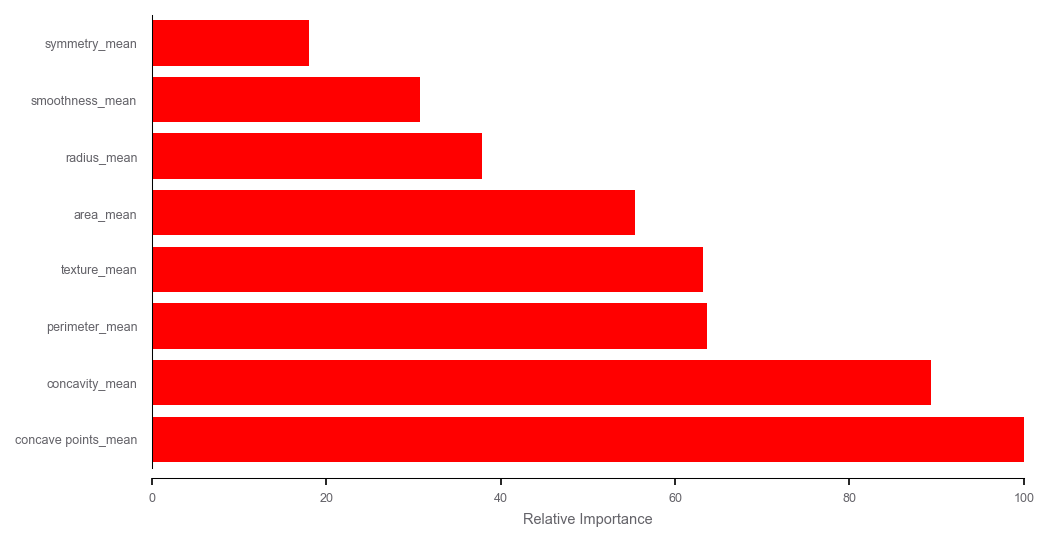

In [100]:
yticks = np.arange(len(relative_importance))
yticklabels = [ri[1] for ri in relative_importance][::-1]
bars_sizes = [ri[0] for ri in relative_importance][::-1]

fig, ax = plt.subplots(figsize=(7.5, 4), dpi=150)
bars = ax.barh(yticks, bars_sizes, height=0.8, color='red')
plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
ax.set_xlim([0, 100])
ax.set_ylim([-0.5, 7.5])
for e in ax.get_yticklabels()+ax.get_xticklabels():
    e.set_fontsize(6)
    e.set_color(GRAY4)
ax.tick_params(left=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + \
         [ax.spines['bottom']]:
    e.set_transform(e.get_transform() + offset)
ax.spines['bottom'].set_bounds(0, 100)
_ = ax.set_xlabel('Relative Importance', color=GRAY4, fontsize=7)
plt.savefig('/Users/MayraBerrones/Documents/VisualCode/relative_importance.png')

In [101]:
def plot_partial_dependence(ax, feature, y_lim):
    n = features.index(feature)
    X_tmp = X.copy()
    vals = np.unique(np.percentile(X_tmp[:, n], np.linspace(1, 99, 100)))
    result = []
    for i in range(vals.shape[0]):
        X_tmp[:, n] = vals[i]
        result.append(np.mean(cb_reg.predict(X_tmp), axis=0)-y_overall_median)
    ax.plot(vals, result, linewidth=0.6, color='#26FF26')
    for e in ax.get_yticklabels() + ax.get_xticklabels():
        e.set_fontsize(4)
    ax.set_ylabel('Partial Dependance', color=GRAY4, fontsize=6)
    ax.set_xlabel(f'{feature}', color=GRAY4, fontsize=6)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.15)

    # plot small red lines for the data deciles
    deciles = np.percentile(X[:, n], np.linspace(10, 90, 9))
    y_from, y_to = y_lim
    for i in range(deciles.shape[0]):
        x = deciles[i]
        ax.plot([x, x], [y_from, y_from+(y_to-y_from)*0.05],
                color='red', linewidth=0.4)
    ax.set_ylim(y_lim)

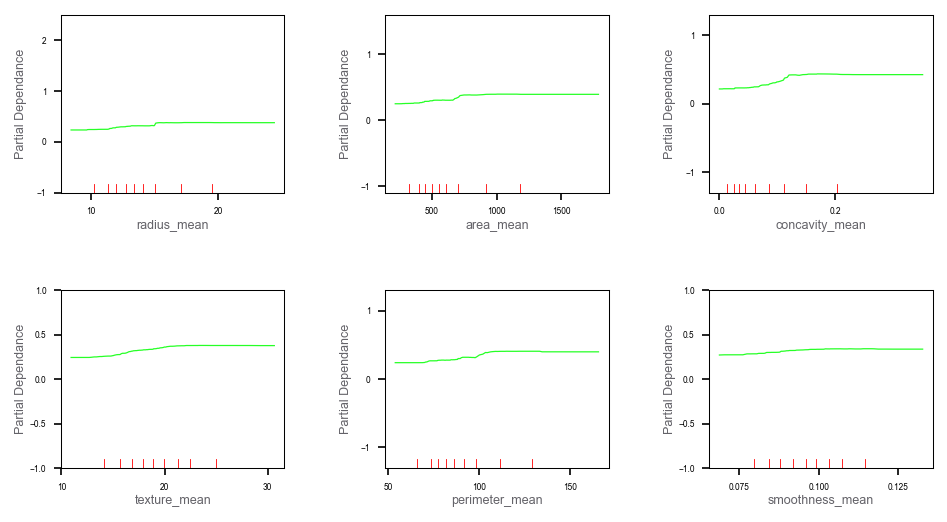

In [102]:
fig, axarr = plt.subplots(2, 3, figsize=(7.5, 4), dpi=150)
plt.subplots_adjust(wspace=0.45, hspace=0.55)
plot_partial_dependence(axarr[0, 0], 'radius_mean', (-1, 2.5))
plot_partial_dependence(axarr[0, 1], 'area_mean', (-1.1, 1.6))
plot_partial_dependence(axarr[0, 2], 'concavity_mean', (-1.3, 1.3))
plot_partial_dependence(axarr[1, 0], 'texture_mean', (-1, 1))
plot_partial_dependence(axarr[1, 1], 'perimeter_mean', (-1.3, 1.3))
plot_partial_dependence(axarr[1, 2], 'smoothness_mean', (-1, 1))
plt.savefig('/Users/MayraBerrones/Documents/VisualCode/partial_dependence.png')


In [103]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# prepare colormap the looks similar to colormap from the book
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 0, N)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(1, 1, N)
newcmp = ListedColormap(vals)

In [104]:
n1, n2 = features.index('symmetry_mean'), features.index('concavity_mean')
vals1, vals2 = np.linspace(1.5, 5.5, 30), np.linspace(5, 50, 30)
N1, N2 = np.meshgrid(vals1, vals2)
Y = np.zeros(shape=N1.shape)

X_tmp = X.copy()
for i in range(N1.shape[0]):
    for j in range(N1.shape[1]):
        X_tmp[:, n1], X_tmp[:, n2] = N1[i, j], N2[i, j]
        Y[i, j] = np.mean(cb_reg.predict(X_tmp), axis=0) - y_overall_median

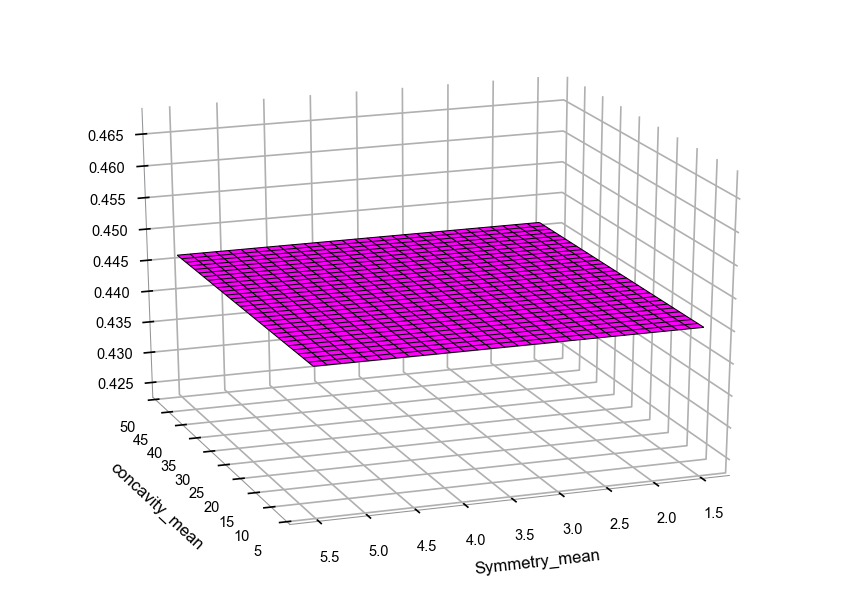

In [105]:
fig = plt.figure(figsize=(7,5), dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('Symmetry_mean', fontsize=8)
ax.set_ylabel('concavity_mean', fontsize=8)
ax.w_xaxis.line.set_color(GRAY7)
ax.w_yaxis.line.set_color(GRAY7)
ax.w_zaxis.line.set_color(GRAY7)
ax.view_init(22, 70)
# invert y-axis
ax.set_ylim(50, 5)
for e in ax.get_yticklabels() + ax.get_xticklabels() + \
         ax.get_zticklabels():
    e.set_fontsize(7)

ax.plot_surface(N1, N2, Y, cmap=newcmp, shade=False)
_ = ax.plot_wireframe(N1, N2, Y, cmap=newcmp, linewidth=0.5, color='black')

In [106]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)


In [107]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9385964912280702


In [108]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from sklearn import metrics
svc=SVC(probability=True, kernel='linear')

abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9298245614035088


In [123]:
# explore adaboost ensemble tree depth effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

In [124]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore depths from 1 to 10
	for i in range(1,11):
		# define base model
		base = DecisionTreeClassifier(max_depth=i)
		# define ensemble model
		models[str(i)] = AdaBoostClassifier(base_estimator=base)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

>1 0.936 (0.033)
>2 0.940 (0.033)
>3 0.943 (0.029)
>4 0.944 (0.028)
>5 0.951 (0.028)
>6 0.943 (0.025)
>7 0.928 (0.040)
>8 0.919 (0.037)
>9 0.914 (0.043)
>10 0.907 (0.038)


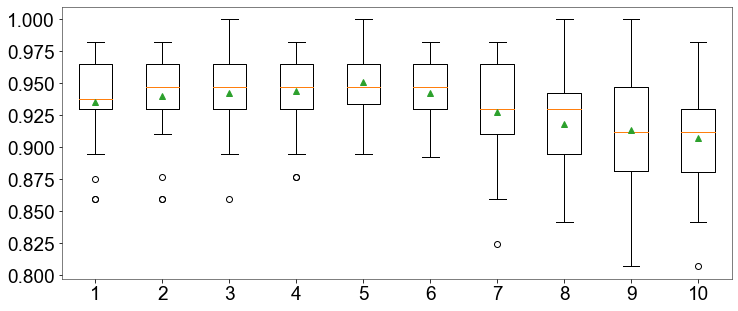

In [134]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.figure(figsize=(12, 5))
pyplot.boxplot(results, labels=names, showmeans=True)

pyplot.xticks(fontsize=19)
pyplot.yticks(fontsize=19)
pyplot.savefig('/Users/MayraBerrones/Documents/VisualCode/adaboost_param.png')

In [136]:
import xgboost as xgb

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

data_dmatrix = xgb.DMatrix(data=X,label=y)


In [138]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

XGBClassifier()


In [140]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.61%


In [115]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.272175


In [117]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.468333,0.000848,0.470664,0.001309
1,0.439488,0.001846,0.444153,0.003134
2,0.414022,0.001728,0.420939,0.003535
3,0.393267,0.001315,0.401144,0.005052
4,0.371968,0.000825,0.381946,0.007093


In [118]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

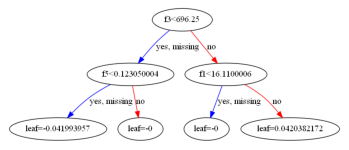

In [119]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [122]:
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster.fit(X_train,y_train)

print(classification_report(y_test,gradient_booster.predict(X_test)))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96        64
           1       1.00      0.90      0.95        50

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

